--- Generating Model Evaluation Dashboard ---
✅ Model loaded from: ../src/models/improved_podium_model.pkl
✅ Data loaded from: ../data/processed/improved_feature_engineered_data.csv

Generating Feature Importance Plot...


/var/folders/6f/761wm_x53rxftvp659wnr6mc0000gn/T/ipykernel_61120/1494868100.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df.head(15), palette='viridis')


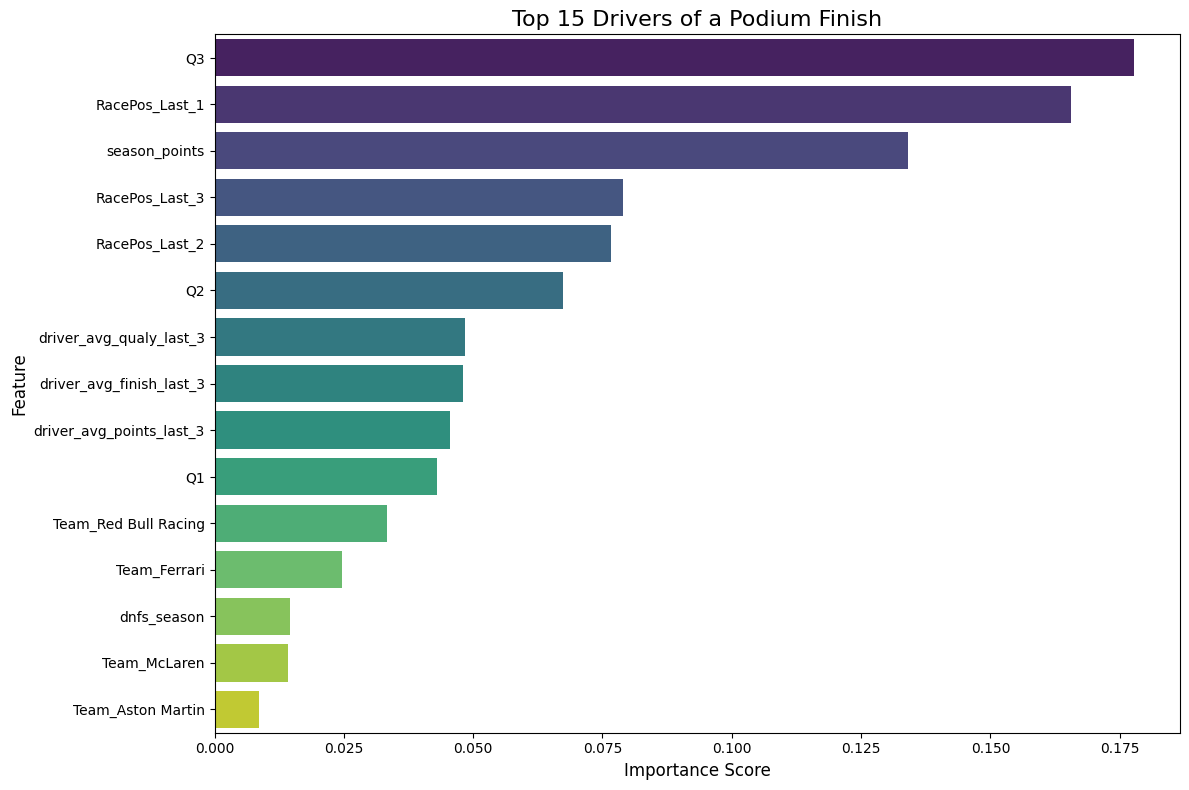

Generating Confusion Matrix...


<Figure size 800x600 with 0 Axes>

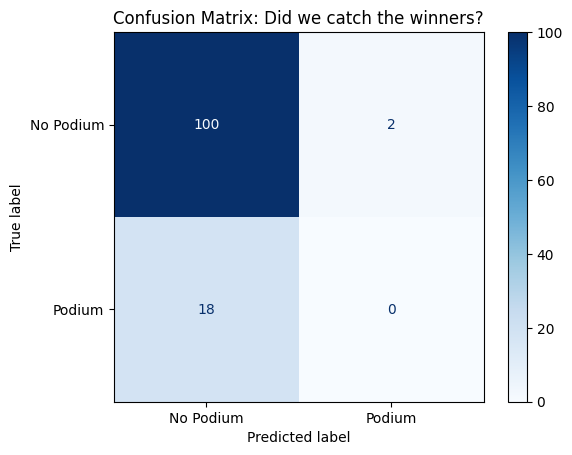


--- Evaluation Complete ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
import os


# --- 1. Load Model and Data ---
model_filename = "improved_podium_model.pkl"
data_filename = "improved_feature_engineered_data.csv"

# Paths to check
model_paths = [
    f"../src/models/{model_filename}", 
    f"../models/{model_filename}", 
    model_filename
]
data_paths = [
    f"data/processed/{data_filename}", 
    f"../data/processed/{data_filename}", 
    data_filename
]

model_path = next((p for p in model_paths if os.path.exists(p)), None)
model = joblib.load(model_path)
print(f"Model loaded from: {model_path}")

# Find and Load Data
data_path = next((p for p in data_paths if os.path.exists(p)), None)
if not data_path:
    print(f"Error: Could not find data file '{data_filename}'")
    exit()
df = pd.read_csv(data_path)
print(f"Data loaded from: {data_path}")


# Reconstruct Features ---
# We need to tell the script which columns are features again
non_feature_cols = [
    'Year', 'RoundNumber', 'FullName', 'EventName', 'TeamName',
    'RacePos', 'Points', 'Laps', 'FinishedRace', 
    'IsRaceWinner', 'IsPodium', 'Time', 'Driver', 'Constructor',
    'GridPosition', 'QualyPos' 
]
# This automatically grabs the numeric columns used for training
features = [col for col in df.columns if col not in non_feature_cols]


# Plot 1: Feature Importance ---
print("\nGenerating Feature Importance Plot...")

importances = model.feature_importances_
fi_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(15), palette='viridis')
plt.title('Top 15 Drivers of a Podium Finish', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


# Confusion Matrix ---
print("Generating Confusion Matrix...")

# First recreate the test set
SPLIT_ROUND = 19
test_mask = (df['Year'] == 2024) & (df['RoundNumber'] >= SPLIT_ROUND)

X_test = df[test_mask][features]
y_test = df[test_mask]['IsPodium']
y_pred = model.predict(X_test)

# Compute and plot matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Podium', 'Podium'])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: Did we catch the winners?')
plt.show()

print("\n--- Evaluation Complete ---")